This notebook analyzes scaling laws when learning on top of frozen embeddings.

It is based off of `notebooks/hf-transfer/probe-scaling.ipynb`. It has the added capability of modeling the embedding distribution with a Gaussian mixture model.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import copy
import dataclasses
import pathlib
import sys
from typing import Any

import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
import torch
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings, probe_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.gmm import GMMDataset
from src.pretrain.datasets.vision import cifar10, imagenette, svhn
from src.pretrain.models.vision import laion_clip, msft_beit, openai_clip

### Load data

In [5]:
def load_embeddings(model_id: str) -> dict[str, Any]:
    dataset_cfg = cifar10.CIFAR10()

    if model_id.startswith("openai"):
        embedder_cfg = openai_clip.OpenaiClipConfig(id=model_id)
    elif model_id.startswith("hf/laion/CLIP"):
        embedder_cfg = laion_clip.LaionClipConfig(id=model_id)
    elif model_id.startswith("hf/microsoft/beit"):
        embedder_cfg = msft_beit.MsftBeitConfig(id=model_id)
    else:
        raise ValueError(model_id)

    embedding_cfg = gen_embeddings.Config(
        dataset_cfg=dataset_cfg,
        embedder_cfg=embedder_cfg,
    )
    probe_cfg = probe_embeddings.Config(
        embedder_cfg=embedder_cfg,
        dataset_cfg=dataset_cfg,
    )

    ds = EmbeddingDataset.load_from_file(embedding_cfg.full_save_path).astype(
        np.float32
    )

    return dict(
        embedding_cfg=embedding_cfg,
        probe_cfg=probe_cfg,
        ds=ds,
    )

In [6]:
# ES = [
#     load_embeddings(id) for id in (
#         "openai/ViT-B/16",
#         "openai/ViT-B/32",
#         "openai/ViT-L/14",
#         "openai/ViT-L/14@336px",
#     )
# ]
ES = [
    load_embeddings(id) for id in (
        "hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K",
        "hf/laion/CLIP-ViT-L-14-laion2B-s32B-b82K",
        "hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K",
        "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    )
]

ES[0]["ds"].xs_train.shape, ES[0]["ds"].ys_train.shape

((50000, 768), (50000,))

### Dataset info

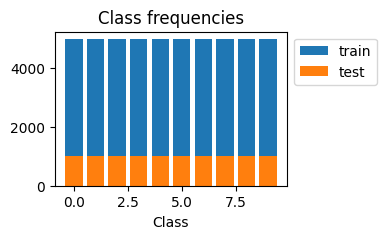

In [7]:
fig = probe_embeddings.plot_class_frequencies(ES[0]["ds"])
fig.set_size_inches(w=3, h=2)

### Fit gaussian proxy model to data

In [8]:
DS_GMMS = [
    GMMDataset.construct_proxy_gpu(
        x["ds"],
        with_label_noise=False,
        cov_eps=1e-6,
    ) for x in ES
]

In [9]:
DS_GMMS_NOISED = [
    GMMDataset.construct_proxy_gpu(
        x["ds"],
        with_label_noise=True,
        cov_eps=1e-6,
    ) for x in ES
]

In [10]:
print(DS_GMMS_NOISED[0].estimate_optimal_error_gpu().mean())
print(
    (
        DS_GMMS_NOISED[0].label_flip_probs.sum()
        - np.diag(DS_GMMS_NOISED[0].label_flip_probs).sum()
    )
    / 10
)


0.019700002
0.020074462890625


### Visualize embeddings with UMAP

In [11]:
for x in ES:
    fig = probe_embeddings.plot_umap(x["ds"], cfg=x["probe_cfg"])
    fig.update_layout(
        width=600,
        height=300,
        title=f"CIFAR10 x {x['probe_cfg'].embedder_cfg.id}",
    )
    fig.show()

### Study evolution of covariances with model scale

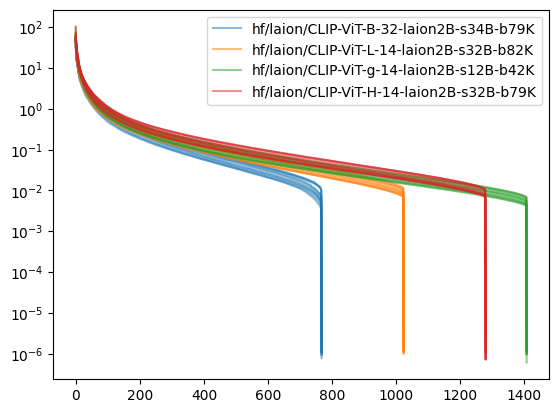

In [18]:
for i, ds_gmm in enumerate(DS_GMMS):
    # svals = np.linalg.svd(ds_gmm.covs, compute_uv=False, hermitian=True)
    # Torch SVD
    svals = torch.linalg.eigvalsh(
        torch.from_numpy(ds_gmm.covs).cuda()
    ).cpu().numpy()[:, ::-1]
    embedder_id = ES[i]["probe_cfg"].embedder_cfg.id
    
    color = None
    for j in range(10):
        ax = plt.plot(
            svals[j],
            color=color,
            label=embedder_id if color is None else None,
            alpha=0.5
        )
        # Get previous color
        color = ax[0].get_color()

plt.yscale("symlog", linthresh=1e-6)
plt.legend();

### Visualize distances between centers

hf/laion/CLIP-ViT-B-32-laion2B-s34B-b79K 0.020074462890625 0.020100001
hf/laion/CLIP-ViT-L-14-laion2B-s32B-b82K 0.00967998504638672 0.0106
hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K 0.00717458724975586 0.0065000006
hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K 0.006932640075683593 0.0084


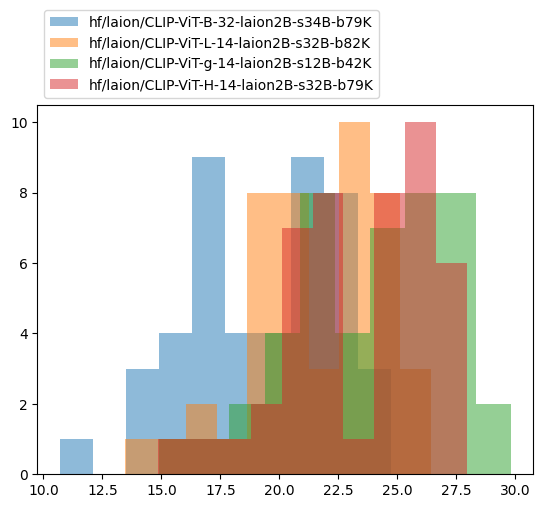

In [25]:
for i, (ds_gmm, ds_gmm_noised) in enumerate(zip(DS_GMMS, DS_GMMS_NOISED)):
    embedder_id = ES[i]["probe_cfg"].embedder_cfg.id
    mus = ds_gmm.mus
    n_classes = mus.shape[0]

    # Get pairwise distances
    dists = scipy.spatial.distance.cdist(mus, mus)

    # Get non-diagonal entries of dists
    dists = dists[np.triu_indices(n_classes, k=1)]

    # Plot histogram
    plt.hist(dists, label=embedder_id, alpha=0.5)
    print(
        embedder_id,
        (
            ds_gmm_noised.label_flip_probs.sum()
            - np.diag(ds_gmm_noised.label_flip_probs).sum()
        )
        / n_classes,
        ds_gmm_noised.estimate_optimal_error_gpu().mean(),
    )

# Legend in outside top left
plt.legend(bbox_to_anchor=(0, 1), loc="lower left")

### Get scaling data

In [26]:
%%capture
dfs = [
    probe_embeddings.get_scaling_results(
        ds=x["ds"],
        cfg=dataclasses.replace(
            x["probe_cfg"], n_classes=(10,), cs=(100,), ks=(1,)
        ),
        with_per_class=False,
    ) for x in ES
]

In [28]:
%%capture
dfs_gmm = [
    probe_embeddings.get_scaling_results(
        ds=ds_gmm.ds,
        cfg=dataclasses.replace(
            x["probe_cfg"], n_classes=(10,), cs=(100,), ks=(1,)
        ),
        with_per_class=False,
    ) for x, ds_gmm in zip(ES, DS_GMMS)
]

In [29]:
%%capture
dfs_gmm_noised = [
    probe_embeddings.get_scaling_results(
        ds=ds_gmm_noised.ds,
        cfg=dataclasses.replace(
            x["probe_cfg"], n_classes=(10,), cs=(100,), ks=(1,)
        ),
        with_per_class=False,
    ) for x, ds_gmm_noised in zip(ES, DS_GMMS_NOISED)
]

### Plot scaling data

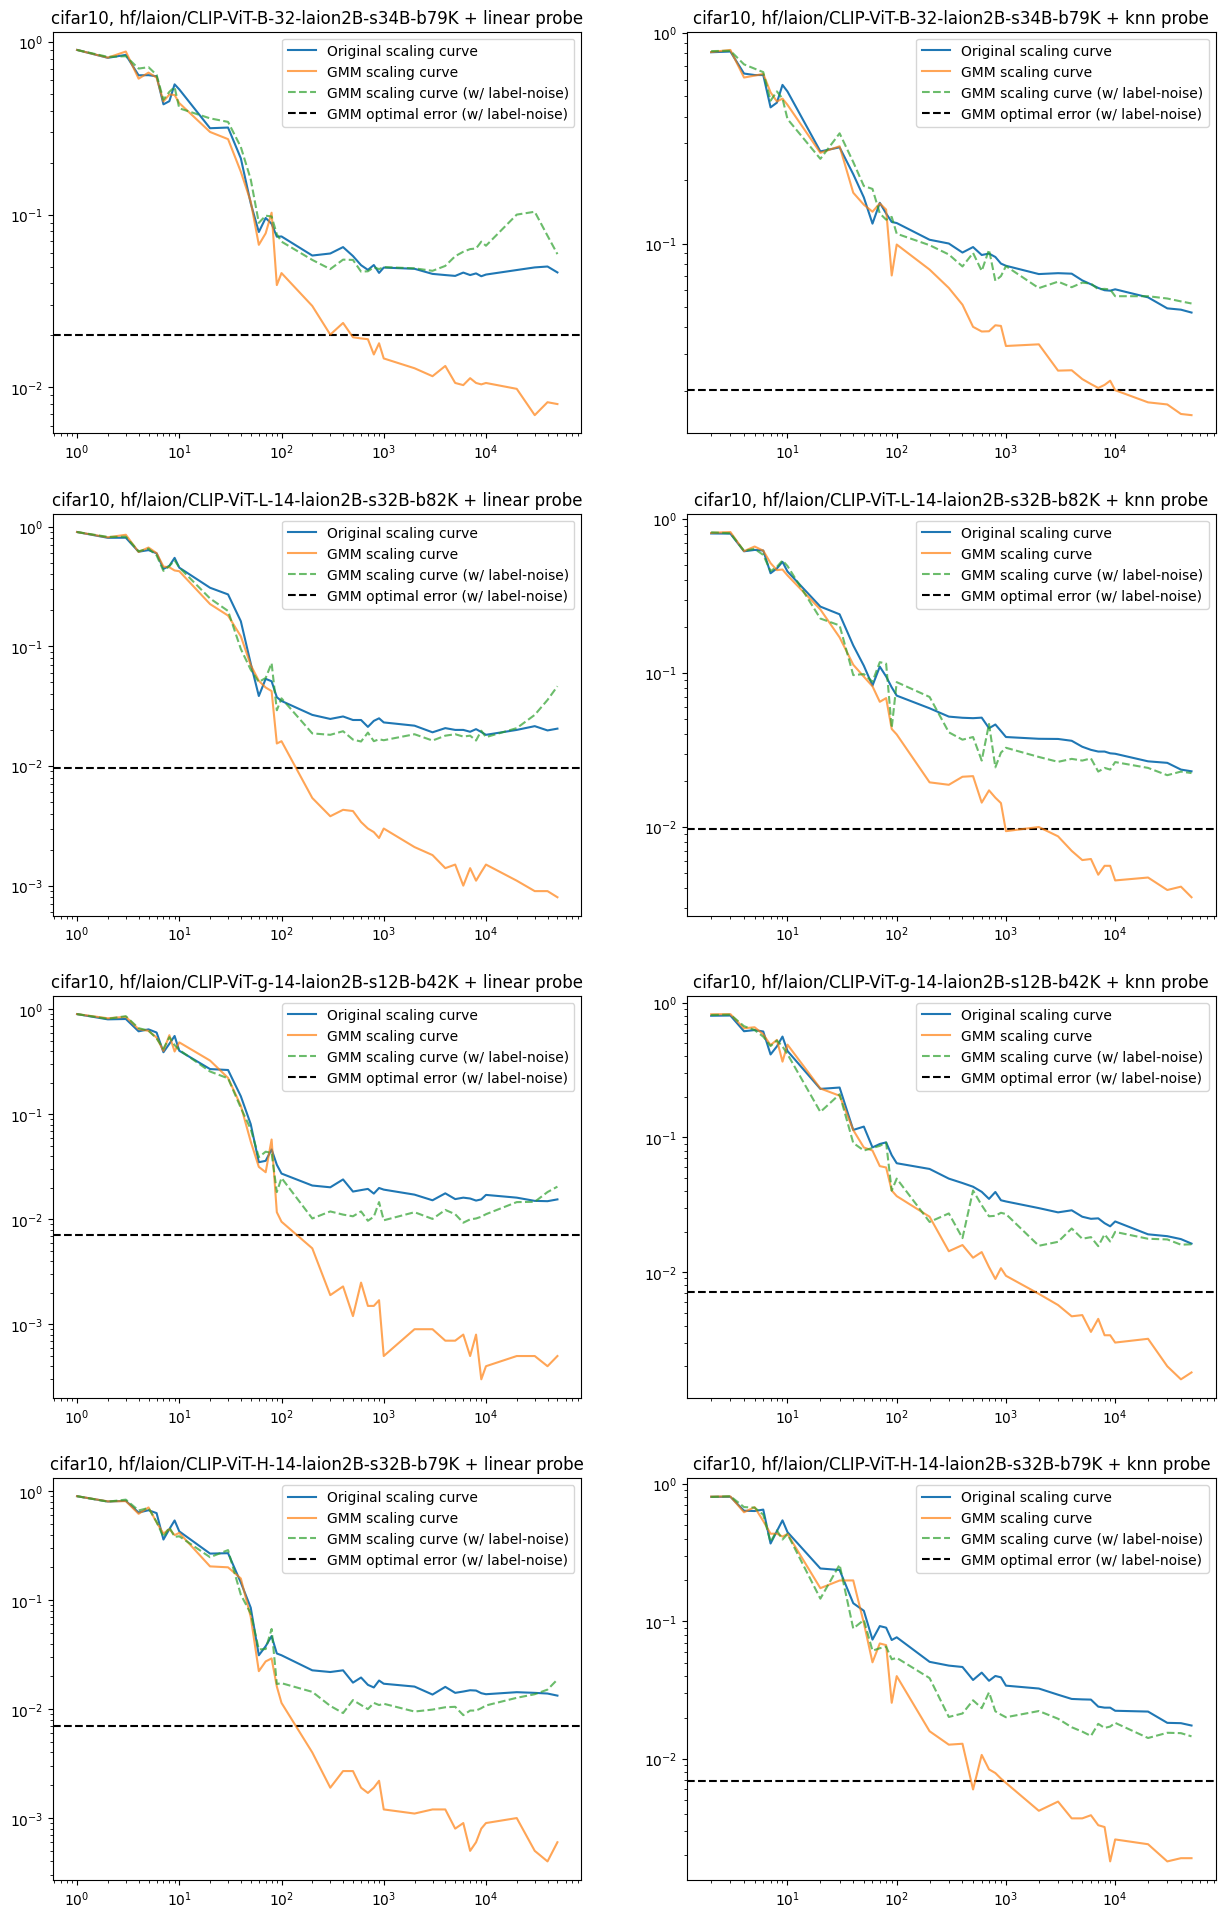

In [33]:
plt.figure(figsize=(15, 24))
for i, (df, df_gmm, df_gmm_noised) in enumerate(
    zip(dfs, dfs_gmm, dfs_gmm_noised)
):
    ds_gmm_noised = DS_GMMS_NOISED[i]
    for j, probe_type in enumerate(("linear", "knn")):
        plt.subplot(len(dfs), 2, 2 * i + j + 1)

        cdf = df.query(f"probe == '{probe_type}' & ~per_class").sort_values(
            "n_train"
        )
        plt.plot(cdf.n_train, cdf.err, label="Original scaling curve")

        cdf = df_gmm.query(f"probe == '{probe_type}' & ~per_class").sort_values(
            "n_train"
        )
        plt.plot(cdf.n_train, cdf.err, label="GMM scaling curve", alpha=0.7)

        cdf = df_gmm_noised.query(
            f"probe == '{probe_type}' & ~per_class"
        ).sort_values("n_train")
        plt.plot(
            cdf.n_train,
            cdf.err,
            label="GMM scaling curve (w/ label-noise)",
            alpha=0.7,
            linestyle="--",
        )
        plt.axhline(
            # ds_gmm_noised.estimate_optimal_error_gpu().mean(),
            (
                ds_gmm_noised.label_flip_probs.sum()
                - np.diag(ds_gmm_noised.label_flip_probs).sum()
            )
            / 10,
            label="GMM optimal error (w/ label-noise)",
            linestyle="--",
            color="black",
            zorder=-1,
        )

        probe_cfg = ES[i]["probe_cfg"]
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.title(
            f"{probe_cfg.dataset_cfg.id}, {probe_cfg.embedder_cfg.id} + {probe_type} probe"
        )
